# API Usage (Automation)
The GUI is designed to demonstrate what is possible. To see how something in the GUI was accomplished, find the tab in `./ipypdf/widgets/node_tools.py` This is where all of the tools are defined. e.g. The `AutoTools` Tab visible in the GUI is a class defined in `node_tools.py` called `AutoTools`.

This notebook just goes through some common interactions.
* Layout extraction
* Cropping
* Table parsing
* Raw text extraction

In [1]:
from pathlib import Path
dir_name = Path("../tests/fixture_data/sample_pdfs")
fname = dir_name / "doc.pdf"

You can call the `parse_layout` or `get_text_blocks` utility functions directly on a pdf without needing to load the ipypdf widget.

### Parse Layout
This function iterates through each page of the doc (you can limit this with start/stop args) and passes the rendered
images through the paddlepaddle model to determine bbox types and boundaries. It returns an iterator of lists. The elements are the default `TextBlock` objects returned by layoutparser with some extra convinience attributes (`relative_coordinates`, and `text`)


This cell complains about needing to initiallize the model. Either of these options will stop the complaints. If you don't mind reloading the model everytime you can safely ignore them.
1. Initialize the model beforehand
```python
import layoutparser as lp
model = lp.models.PaddleDetectionLayoutModel("lp://PubLayNet/ppyolov2_r50vd_dcn_365e/config")
blocks = list(parse_layout(fname, model))
```
2. Supress the Warning
```python
blocks = list(parse_layout(fname, ignore_warning=True))
```

In [2]:
from ipypdf.utils.lp_util import parse_layout
blocks = list(parse_layout(fname))

c:\git\ipypdf\ipypdf\utils\lp_util.py:45: UserWarning: No model provided: loading 'ppyolov2_r50vd_dcn_365e'
  warnings.warn("No model provided: loading 'ppyolov2_r50vd_dcn_365e'")


In [3]:
# blocks[page][index].attribute
b = blocks[0][0]
print(f"{b.type}: {b.text}")

Title: Test Document For iPyPDF


From the `coordinates` attribute you can crop out the portion of the document pertaining to the Text block

> Note: The ImageContainer object by default renders the pdf at 300 dpi. If this scaling changes, then the pil coordinates will be wrong.<br>
This is the reasoning behind `relative_coordinates`

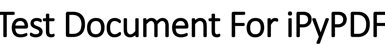

In [4]:
from ipypdf.utils.image_utils import ImageContainer
imgs = ImageContainer(fname)
im = imgs[0].crop(b.coordinates)
im.resize((im.width//3,im.height//3))

## Table Parsing Example

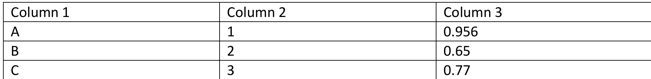

In [5]:
tables = []

# Iterate through blocks until we find a "Table"
for page, page_blocks in enumerate(blocks):
    for block in page_blocks:
        if block.type == "Table":
            # Crop out the table
            tables.append(
                imgs[page].crop(block.coordinates)
            )
im = tables[0]
im.resize((im.width//3,im.height//3))

In [6]:
from ipypdf.utils.table_extraction import img_2_table
# Parse the table using the img_2_table utility function
img_2_table(tables[0])

[[((10, 7, 649, 58), 'Column 1'),
  ((659, 7, 650, 58), 'Column 2'),
  ((1309, 7, 644, 58), 'Column 3')],
 [((10, 65, 649, 58), ''),
  ((659, 65, 650, 58), ''),
  ((1309, 65, 644, 58), '0.956')],
 [((10, 123, 649, 58), ''),
  ((659, 123, 650, 58), ''),
  ((1309, 123, 644, 58), '0.65')],
 [((10, 181, 649, 55), ''),
  ((659, 181, 650, 55), ''),
  ((1309, 181, 644, 55), '0.77')]]

### Get Text Blocks
This is passes each page through Tesseract to get text boxes. The text blocks are indexed the same way the `LP` results. But in this case each block is just a dictionary.


In [7]:
from ipypdf.utils.tess_utils import get_text_blocks
[[b["value"] for b in page] for page in get_text_blocks(fname)]

[['Test Document For iPyPDF',
  'Disclaimer: This document was specifically formatted to give the best-case scenario for layout detection. It is used to test the ability of ipypdf to correctly handle different types of content.',
  ' ',
  'Lorem ipsum dolor sit amet, consectetur adipiscing elit. Praesent dignissim augue quis lectus ullamcorper, eget efficitur ipsum fringilla. Vivamus elementum mollis nisi, id iaculis urna efficitur id. Vivamus magna sem, maximus sit amet sapien sed, iaculis faucibus neque. Sed id lacus cursus, efficitur sem et, aliquam magna. Duis molestie magna sed eros rhoncus sagittis. Suspendisse potenti. Curabitur malesuada ligula ut pretium pellentesque.',
  'Heading 1 (Pure Text)',
  'This is just normal text. It should be identified as such.',
  'Lorem ipsum dolor sit amet, consectetur adipiscing elit. Praesent dignissim augue quis lectus ullamcorper, eget efficitur ipsum fringilla. Vivamus elementum mollis nisi, id iaculis urna efficitur id. Vivamus magna sem,

In [8]:
list(get_text_blocks(fname))[0][0]

{'value': 'Test Document For iPyPDF',
 'page': 0,
 'rel_coords': [0.11725490196078431,
  0.5788235294117647,
  0.10148439866707058,
  0.13147531051196606],
 'pil_coords': [299, 335, 1476, 434]}